# Recreating SIFT Detector

I learned about the SIFT detection algorithm for images and how it can be used for various things (structure from motiom, feature tracking, etc). I'm going to try and reimplement it using OpenCV, scikit-image, and numpy (not using the SIFT detector in OpenCV for now).

I got this nice image we're going to use for testing this

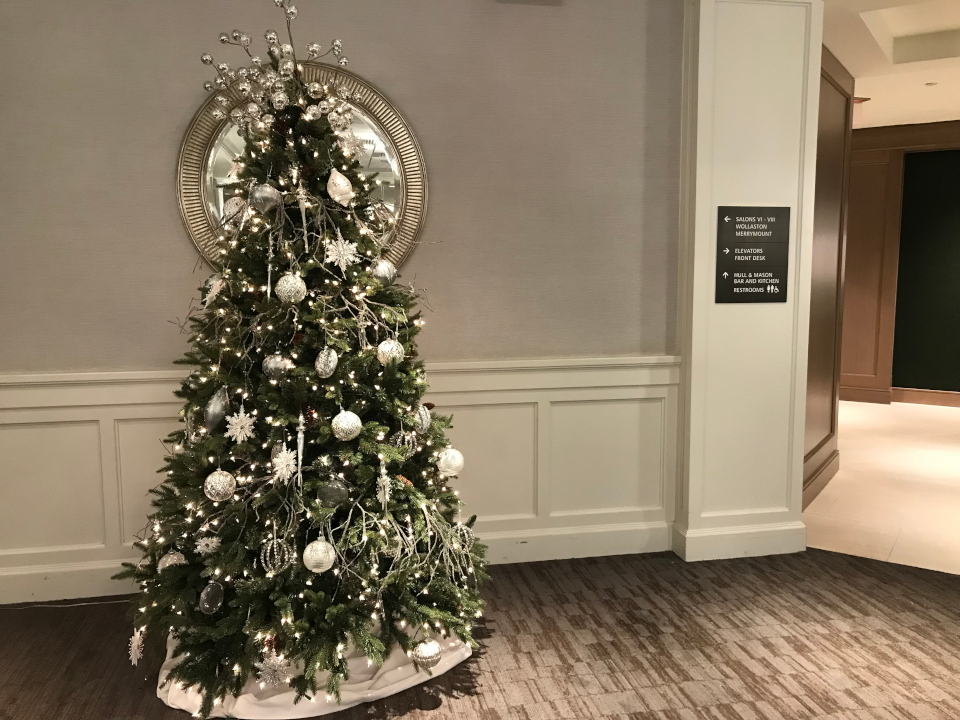

In [21]:
import cv2
import numpy as np
from anutils import data_path
from IPython import display as disp
from ipywidgets import IntSlider, FloatSlider, Button, Output, VBox
from matplotlib import pyplot as plt
import skimage as ski
from tqdm.notebook import tqdm

# Configuration
fa, fb = figscale = (7, 2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (4 * fa // fb, 3 * fa // fb)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2)

def display_sample_of_3d(image3d, labels, x=3, y=3, m=None):
    fig, axs = plt.subplots(x, y)
    c = x*y
    m = m or len(labels) // c
    for i in range(c):
        axs.flat[i].imshow(image3d[m*i,:,:])
        axs.flat[i].set_title(labels[m*i])

image_file = data_path / 'sift-detector-example.jpg'

disp.Image(str(image_file), embed=True)

## SIFT detector

Let's first get a single still from this video and see what we can produce from it. We'll convert it to grayscale to make things a bit easier for us to write the detector.

(720, 960) float64


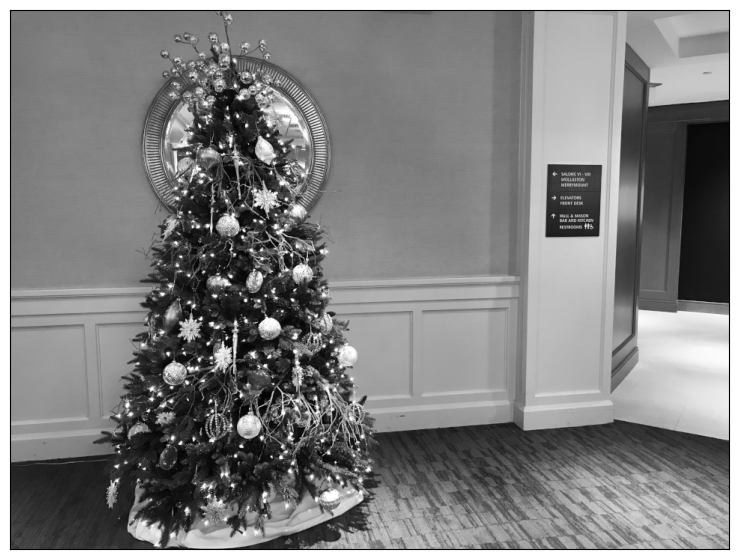

In [18]:
img = cv2.imread(str(image_file))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
float_img = gray_img.astype(np.float64)

print(float_img.shape, float_img.dtype)
plt.imshow(float_img)
plt.show()

The first thing we need to do is create a stack of gaussians with different sigma ($\sigma$) values. We'll create a logarithmic range of sigmas according to the formula:

$$
\sigma_k = \sigma_0 s^k
$$

We'll set $\sigma_0$ and $s$ depending on what works best

In [36]:
sigma_0 = 10.0
sigma_f = 120
count = 200

range_stop = np.log10(sigma_f/sigma_0)
sigmas = sigma_0 * np.logspace(0, range_stop, num=count)
sigmas

array([ 10.  ,  10.13,  10.25,  10.38,  10.51,  10.64,  10.78,  10.91,
        11.05,  11.19,  11.33,  11.47,  11.62,  11.76,  11.91,  12.06,
        12.21,  12.36,  12.52,  12.68,  12.84,  13.  ,  13.16,  13.33,
        13.49,  13.66,  13.84,  14.01,  14.19,  14.36,  14.54,  14.73,
        14.91,  15.1 ,  15.29,  15.48,  15.68,  15.87,  16.07,  16.27,
        16.48,  16.69,  16.9 ,  17.11,  17.32,  17.54,  17.76,  17.98,
        18.21,  18.44,  18.67,  18.9 ,  19.14,  19.38,  19.63,  19.87,
        20.12,  20.38,  20.63,  20.89,  21.15,  21.42,  21.69,  21.96,
        22.24,  22.52,  22.8 ,  23.09,  23.38,  23.67,  23.97,  24.27,
        24.57,  24.88,  25.19,  25.51,  25.83,  26.16,  26.48,  26.82,
        27.15,  27.5 ,  27.84,  28.19,  28.55,  28.9 ,  29.27,  29.63,
        30.01,  30.38,  30.77,  31.15,  31.54,  31.94,  32.34,  32.75,
        33.16,  33.58,  34.  ,  34.43,  34.86,  35.3 ,  35.74,  36.19,
        36.64,  37.1 ,  37.57,  38.04,  38.52,  39.  ,  39.49,  39.99,
      

Then, for each sigma, we'll do a gaussian filter on the image to create a stack of filtered images. This will simulate viewing the image at different resolutions/scales

Computing Gaussians:   0%|          | 0/200 [00:00<?, ?it/s]

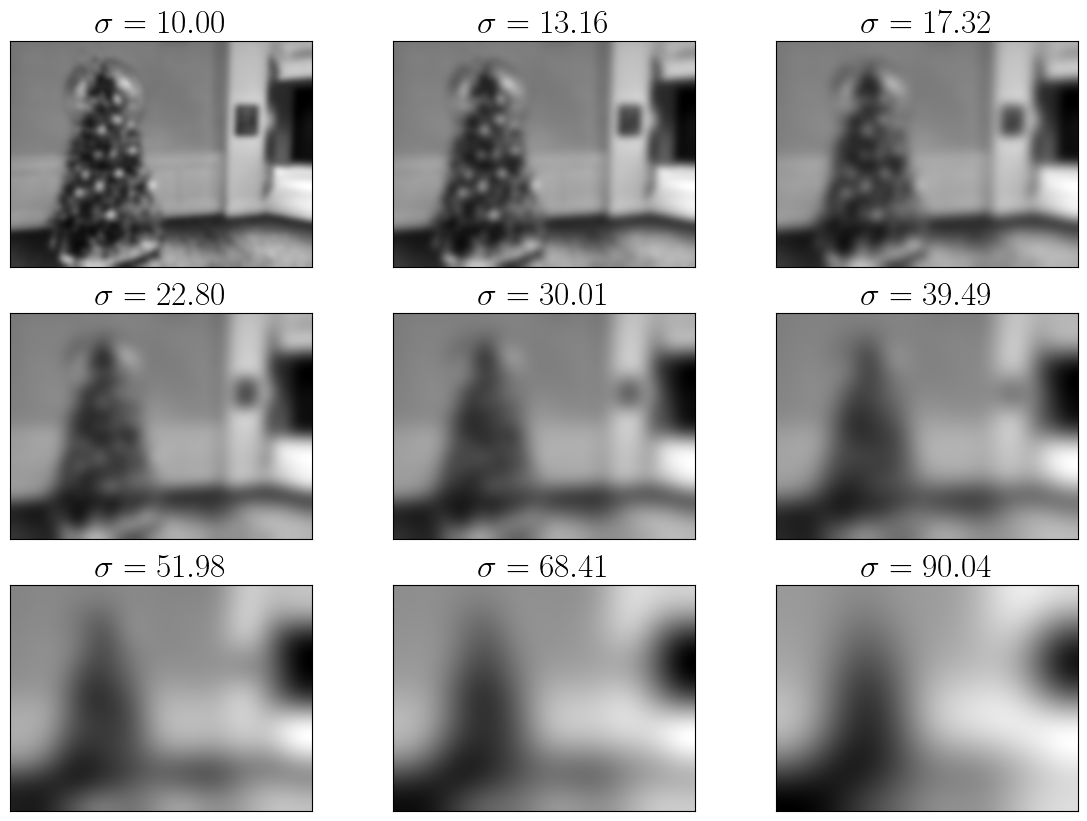

In [37]:
gaussians = np.array([ 
    cv2.GaussianBlur(float_img, (0,0), sigma) 
    for sigma in tqdm(sigmas, desc='Computing Gaussians')
])
sigma_labels = [ f'$\sigma = {s:.2f}$' for s in sigmas ] # erm... what the sigma

display_sample_of_3d(gaussians, sigma_labels)

Now we'll compute Differences of Gaussians (which we can call DOGs, lmao) by subtracting adjacent gaussians in each row.

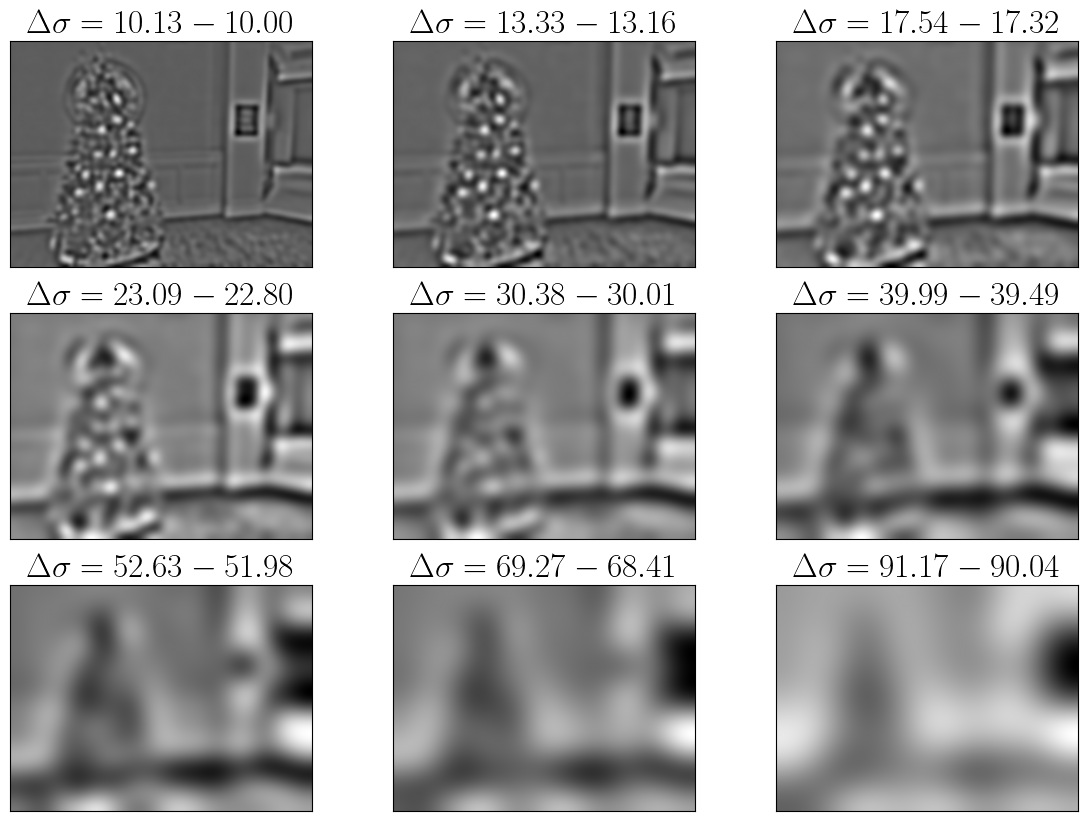

In [38]:
dogs = gaussians[:-1,:,:] - gaussians[1:,:,:]
delta_labels = [ f'$\Delta \sigma = {b:.2f} - {a:.2f}$' for a,b in zip(sigmas[:-1],sigmas[1:]) ] # erm... what the dog
display_sample_of_3d(dogs, delta_labels)

The (almost) final step is to find all local maximas in this 3D stack of images.

In [39]:
extrema = ski.feature.peak_local_max(dogs)
extrema

array([[  6, 553, 320],
       [  4, 553, 319],
       [  8, 554, 320],
       ...,
       [ 10, 643,  49],
       [ 12, 645,  50],
       [130, 202,   1]])

As can be seen we actually get 3 bits of information. We have the x/y coordinate of the feature in the image, but we also have the scale that the feature encompasses based on it's first coordinate. We can plot these as circles on the original image with the radius equal to the scale of the image

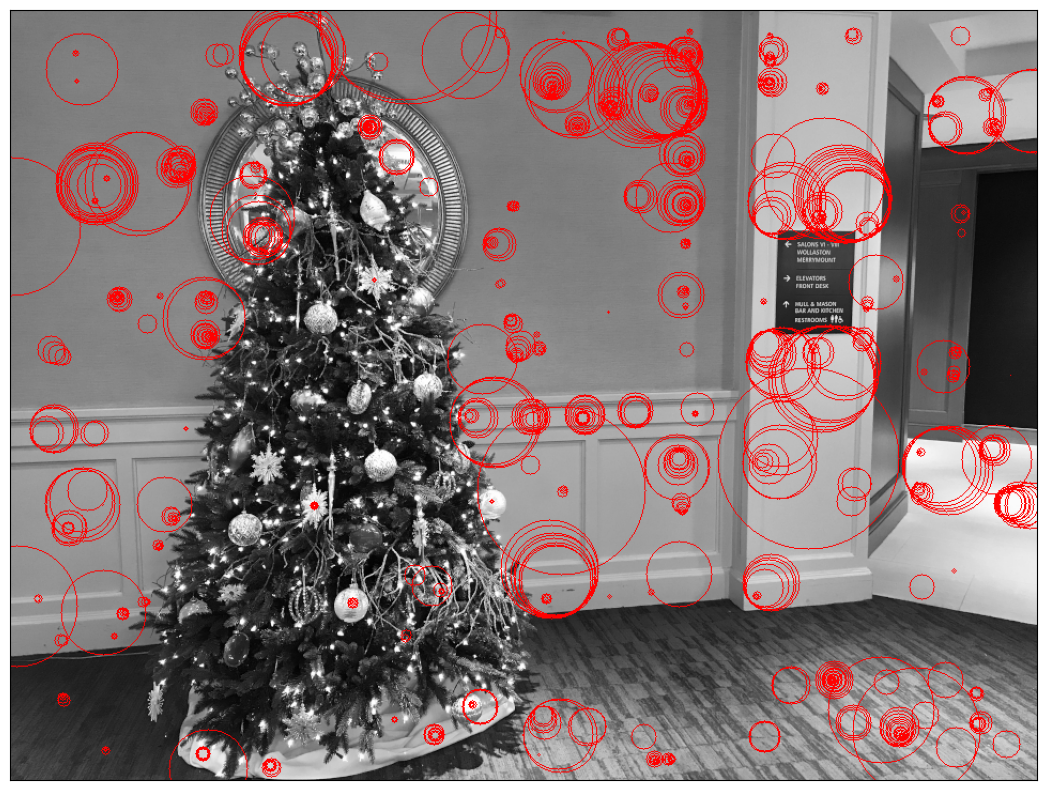

In [40]:
display_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
for s, y, x in extrema:
    display_img = cv2.circle(display_img, (x,y), s//2, (255, 0, 0))
plt.imshow(display_img)
plt.show()

OpenCV has a SIFT detector of it's own. I'll compare what I have to what it outputs

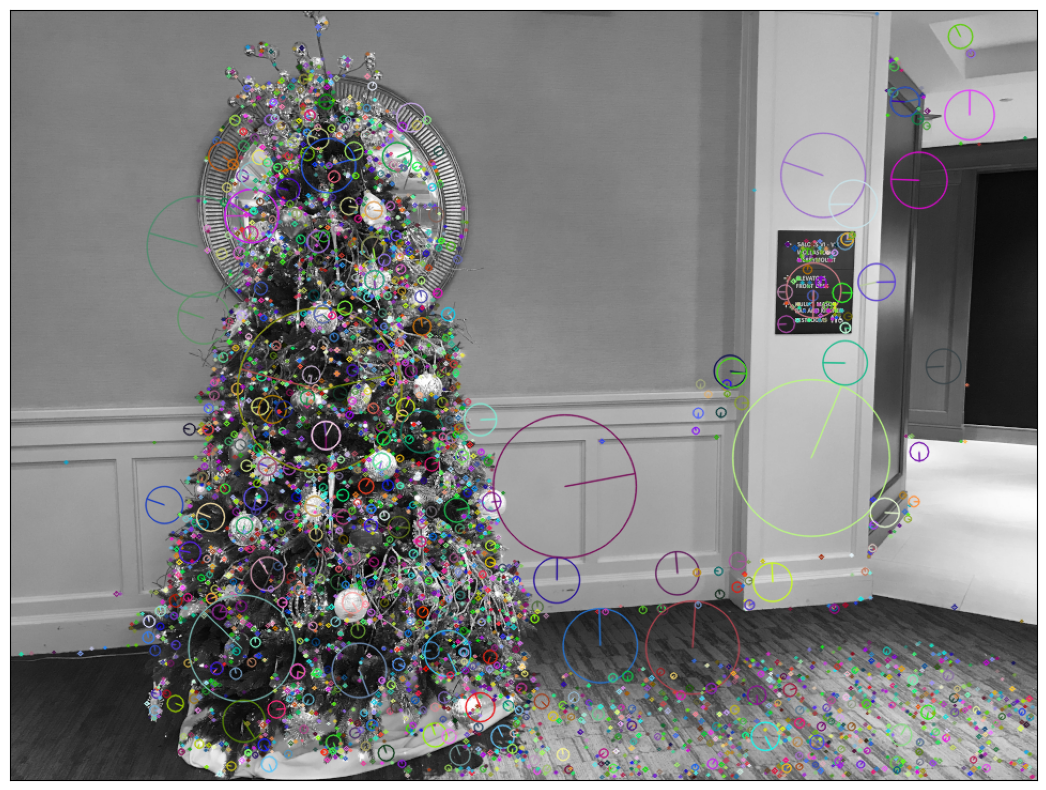

In [41]:
# Detect object using SIFT
sift = cv2.SIFT.create()
keypoints = sift.detect(gray_img)
flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
frame_with_keypoints = cv2.drawKeypoints(gray_img, keypoints, None, flags=flags)

# Show objects
plt.imshow(frame_with_keypoints)
plt.show()

Obviously OpenCV's version is much better and faster than my version. But I'm surprised mine worked! And it's pretty close too! I'll be making another notebook focused on using SIFT to stitch images together. So, I'll use OpenCV's version in that.